# TP1 :  Discrétisation de l'équation de transport

In [1]:
import numpy
import os
import math

import scipy.sparse as sparse
import scipy.sparse.linalg

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

### Equation de transport :
Soit $T > 0$.
On considère le domaine de calcul (temps-espace) $]0,T[ \times ]0,1[$.
On souhaite discrétiser l'équation de transport avec des conditions aux limites périodiques:
$$\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0 \text{ dans } ]0,1[,$$
$$u(t,0) = u(t,1) \text{ pour } t \in ]0,T[,$$
$$u(0,x) = u_0(x) \text{ pour } x \in ]0,1[,$$
où $a \in \mathbb{R}$ est la vitesse de transport et $u_0$ est une fonction représentant la valeur initiale de $u$.

### Discrétisation du domaine :
On discrétise le domaine spatial $]X_{\text{min}},X_{\text{max}}[$ par $M>0$ sous-intervalles (dans la suite $X_{\text{min}}=0$ et $X_{\text{max}}=1$). 
Les points correspondant à cette discrétisation sont les $x_i = X_{\text{min}} + i h$ avec $h = \frac{X_{\text{max}} - X_{\text{min}}}{M}$ ($0 \leq i \leq M$).

In [2]:
def discretisation_x(X_min,X_max,M):
    h = 1/M*(X_max-X_min)
    X = numpy.zeros(M+1)
    for i in range(0,M+1):
        X[i] = X_min + i*h
    return X

On discrétise le domaine temporel $]0,T[$ par $N>0$ sous-intervalles. 
Le pas de temps sera obtenu par $\Delta t = \frac{T}{N}$.

In [3]:
Temps_final = 2

### Condition initiale et solution exacte :

On se donne pour condition initiale la fonction
$$u_0(x) = \sin(2 \pi x)$$
et on considère une vitesse de transport $a= \frac12$.

On peut alors calculer la solution exacte de ce problème (cf cours):
$$u(t,x) = u_0(x-at - E(x-at))$$
avec $E(x)$ la partie entière de $x$.

In [4]:
# fonction initiale
def u_ini(x):
    return numpy.sin(2*numpy.pi*x)

# vitesse
a = 0.5

# sol exacte
def u_ex(t,x):
    pos = x-a*t
    return u_ini(pos - math.floor(pos) )


On cherche à construire une suite $(u_i^n)_{\substack{0 \leq n \leq N \\ 0 \leq i \leq M-1}}$ approchant la solution exacte.

Tous les schémas considérés seront initialisés avec la condition :
$$u_i^0 = u_0(x_i) \text{ pour } 0 \leq i \leq M-1.$$

### Schéma explicite centré :

Commençons par considérer le schéma explicite centré suivant:
$$u_i^{n+1} = u_i^n - \frac{a \Delta t}{2h}(u_{i+1}^n - u_{i-1}^n) \text{  pour  } 0 \leq i \leq M-1 \text{ et } 0 \leq n \leq N-1$$
avec la convention $u_M^n = u_0^n$ et $u_{-1}^n = u_{M-1}^n$.
La fonction suivante doit renvoyer un tableau à deux entrées contenant les valeurs de la suite $(u_i^n)$.

In [5]:
def schema_exp_cen(N,M):
    u = numpy.zeros((N+1, M))
    # initialisation de la solution avec u_ini
    X = discretisation_x(0,1,M)
    h = 1/M
    u[0,:] = u_ini(X[0:M])

    # calcul de la solution discrete
    dt = Temps_final/N
    for n in range(0,N):
        for i in range(0,M-1):        
            u[n+1,i] = u[n,i] - 0.5*a*dt/h * ( u[n,i+1] -  u[n,i-1])
        u[n+1,M-1] = u[n,M-1] - 0.5*a*dt/h * ( u[n,0] -  u[n,M-2])
    return u

On peut maintenant tracer la solution approchée au temps $t=T$ et la comparer avec la solution exacte.
La fonction suivante doit tracer sur un même graphe la solution générée par le schéma et la solution exacte (au temps final).

In [6]:
def plot_ec(N,M):
    X = discretisation_x(0,1,M)
    # sol approchee
    u_ec = numpy.zeros(M+1)
    u_num = schema_exp_cen(N,M)
    u_ec[0:M] = u_num[N,:]
    u_ec[M] = u_ec[0]
    plt.figure()
    plt.plot(X, u_ec)

    # sol exacte
    u_sol = numpy.zeros(M+1)
    for i in range(M+1):
        u_sol[i] = u_ex(Temps_final,X[i])
    plt.plot(X, u_sol)


On peut maintenant appeler cette fonction pour différents $N$ et $M$. On doit observer une instabilité qui se développe et devient plus grande quand on raffine $N$ et $M$.

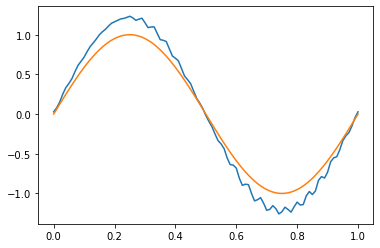

In [7]:
# essayer plusieurs valeurs   
plot_ec(100,100)

### Schéma explicite décentré :

Pour remedier à cette instabilité, on se propose d'utiliser le schéma explicite décentré suivant:
$$u_i^{n+1} = u_i^n - \frac{a \Delta t}{h}(u_i^n - u_{i-1}^n) \text{ pour } 0 \leq n \leq N-1 \text{ et } 0 \leq i \leq M-1 ,$$
où on a utilisé la convention $u_{-1} = u_{M-1}$.

On rappelle que ce schéma est stable sous la condition de CFL
$$a \Delta t \leq h$$

La fonction suivante calcule les valeurs générées par ce schéma.

In [8]:
def schema_exp_dec(N,M):
    # initialisation
    X = discretisation_x(0,1,M)
    h = 1/M
    u = numpy.zeros((N+1,M))
    u[0,:] = u_ini(X[0:M])
    
    # boucle en temps
    dt = Temps_final/N
    for n in range(0,N):
        for i in range(0,M):
            u[n+1,i] = u[n,i] - a*dt/h * (u[n,i] - u[n,i-1])
            
    return u


La fonction suivante compare graphiquement la solution approchée avec la solution exacte au temps final.

In [9]:
def plot_ed(N,M):
    X = discretisation_x(0,1,M)
    u_num = schema_exp_dec(N,M)
    u_ed = numpy.zeros(M+1)
    u_ed[0:M] = u_num[N,:]
    u_ed[M] = u_ed[0]
    plt.figure()
    plt.plot(X, u_ed)

    # sol exacte
    u_sol = numpy.zeros(M+1)
    for i in range(M+1):
        u_sol[i] = u_ex(Temps_final,X[i])
    plt.plot(X, u_sol)



Vérifier qu'une instabilité se développe si on ne respecte pas la condition de CFL
$$a \Delta t \leq h$$
et que tout se passe bien si on respecte cette condition.
(tester plusieurs valeurs de $N$ et $M$)

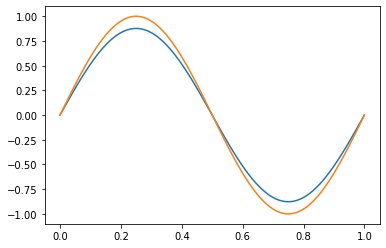

In [10]:
plot_ed(300,100)

### Schéma implicite centré :

Considérons maintenant le schéma implicite centré :
$$u_i^{n+1} = u_i^n - \frac{a \Delta t}{2h}(u_{i+1}^{n+1} - u_{i-1}^{n+1}) \text{ pour } 0 \leq n \leq N-1 \text{ et } 0 \leq i \leq M-1 ,$$
avec la convention $u_{-1}^n = u_{M-1}^n$ et $u_M^n = u_0^n$.

On obtient la solution au temps $t^{n+1}$ à partir du temps $t^n$ en résolvant le système linéaire suivant:
$$A U^{n+1} = U^n$$
avec
$$
U^n = \begin{pmatrix} u_0^n \\ u_1^n \\ \vdots \\ u_{M-1}^n \end{pmatrix}
\qquad \text{ et } \qquad
A = \begin{pmatrix} 
1 & \frac{a \Delta t}{2h} & 0 & & 0 & -\frac{a \Delta t}{2h} 
\\
-\frac{a \Delta t}{2h} & \ddots & \ddots& 0 & & 0
\\
0 & \ddots & \ddots & \ddots & 0
\\
 & & \ddots & \ddots & \ddots &
\\
0 & & & \ddots & \ddots & \frac{a \Delta t}{2h}
\\
\frac{a \Delta t}{2h}& 0 & & 0 & -\frac{a \Delta t}{2h} & 1
\end{pmatrix}$$

La fonction suivante calcule la matrice A.

In [11]:
# assemblage d'une matrice creuse A (pour un schema implicite)
def mat_A(N,M):
    h = 1/M
    dt = Temps_final/N
    
    row = list()
    col = list()
    data = list()
    for i in range(0,M):
    
        # A_i,i = qque chose (exemple)
        row.append((i))
        col.append((i))
        data.append( 1 )  
    
        # A_i,i-1 = autre chose (exemple)
        row.append((i))
        col.append((numpy.mod(i-1,M)))  # modulo pour conditions periodiques
        data.append( -0.5*a*dt/h )
    
        # A_i,i+1 = encore autre chose
        row.append((i))
        col.append((numpy.mod(i+1,M))) # modulo pour conditions periodiques
        data.append( 0.5*a*dt/h )

    row = numpy.array(row)
    col = numpy.array(col)
    data = numpy.array(data)      
    A = (sparse.coo_matrix((data, (row, col)), shape=(M, M))).tocsr()
    return A

La fonction suivante calcule les valeurs générées par le schéma.

In [12]:
# calcul de la solution du schema implicite
def schema_imp_cen(N,M):
    X = discretisation_x(0,1,M)
    A = mat_A(N,M)
    u_i = numpy.zeros((N+1,M))
    u_i[0,:] = u_ini(X[0:M])
    for n in range(0,N):
        u_i[n+1,:] = sparse.linalg.spsolve(A, u_i[n,:])
    return u_i

La fonction suivante affiche la solution approchée et la solution exacte au temps final.

In [13]:
# affichage du resultat
def plot_ic(N,M):
    # solution approchee
    X = discretisation_x(0,1,M)
    u_num = schema_imp_cen(N,M)
    u_ic = numpy.zeros(M+1)
    u_ic[0:M] = u_num[N,:]
    u_ic[M] = u_ic[0]
    plt.figure()
    plt.plot(X, u_ic)
    
    # solution exacte
    u_sol = numpy.zeros(M+1)
    for i in range(M+1):
        u_sol[i] = u_ex(Temps_final,X[i])
    plt.plot(X, u_sol)

On peut vérifier qu'aucune instabilité n'apparaît quelles que soient les valeurs de $N$ et $M$.

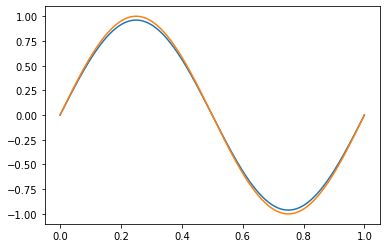

In [14]:
# tester différentes valeurs de N et M
plot_ic(500,500)

### Comparaison des différents schémas :

On se propose maintenant de comparer l'évolution au cours du temps de la solution de ces trois schémas avec la solution exacte.

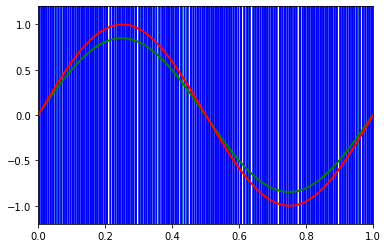

In [15]:
M = 150
N = 120

X = discretisation_x(0,1,M)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

# on garde les bornes pour afficher les solutions
u_ec = schema_exp_cen(N,M)
u_ed = schema_exp_dec(N,M)
u_ic = schema_imp_cen(N,M)
u_min = min(u_ec[0,:])
u_max = max(u_ec[0,:])
Y_min = u_min - 0.1*(u_max-u_min)
Y_max = u_max + 0.1*(u_max-u_min)    

ax.set_xlim(( 0, 1))
ax.set_ylim((Y_min, Y_max))

line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2, color='b')
line3, = ax.plot([], [], lw=2, color='g')
line4, = ax.plot([], [], lw=2, color='r')

def init():
    line.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    return (line,line2, line3, line4)
def animate(nt):
    # schema explicite centre
    u_1 = numpy.zeros(M+1)
    u_1[0:M] = u_ec[nt,:]
    u_1[M] = u_1[0]
    line.set_data(X, u_1)
    
    # schema explicite decentre
    u_2 = numpy.zeros(M+1)
    u_2[0:M] = u_ed[nt,:]
    u_2[M] = u_2[0]
    line2.set_data(X, u_2)
    
    # schema implicite centre
    u_3 = numpy.zeros(M+1)
    u_3[0:M] = u_ic[nt,:]
    u_3[M] = u_3[0]
    line3.set_data(X, u_3)
    
    # solution exacte
    dt = Temps_final/N
    sol_ex = numpy.zeros(M+1)
    for i in range(0,M+1):
        sol_ex[i] = u_ex(nt*dt,X[i])
    line4.set_data(X, sol_ex)
    return (line,line2, line3, line4)

# call the animator. 
# interval: Delay between frames in milliseconds. Defaults to 200.
# blit=True means only re-draw the parts that have changed.
# see https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N+1, interval=20, blit=True)
HTML(anim.to_html5_video())

### Ordre de convergence :

Estimons maintenant l'ordre de la méthode explicite décentrée avec une CFL de 0.8.
Tracer en échelle log-log l'évolution de l'erreur $\max_{0 \leq n \leq N} \max_{0 \leq i \leq M} |u_i^n - u(t_n,x_i)|$ en fonction de M en choisissant $N$ tel que l'on ait $\frac{a \Delta t}{h} = 0.8$.

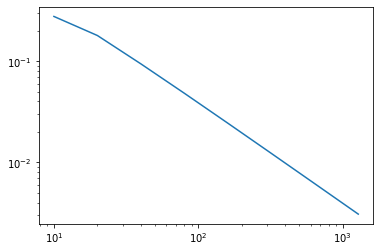

In [16]:
CFL = 0.8

liste_M = [10,20,40,80,160,320, 640, 1280]
liste_err = []

for M in liste_M:
    # calcul de N 
    N = math.floor(a*M*Temps_final/CFL)
    # calcul de la solution discrete
    u_ed = schema_exp_dec(N,M)
    # calcul de la solution exacte au temps final
    X = discretisation_x(0,1,M)
    sol_ex = numpy.zeros(M)
    for i in range(0,M):
        sol_ex[i] = u_ex(Temps_final,X[i])
    # calcul de l'erreur max
    err_max = 0
    for i in range(0,M):
        err_i = abs(u_ed[N,i] - sol_ex[i])
        if(err_i > err_max):
            err_max = err_i
    liste_err.append(err_max)


plt.plot(liste_M, liste_err)
plt.loglog()
plt.show()

On doit retrouver le fait que la méthode est d'ordre 1